In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
!pip install tensorflow_decision_forests
# wurlitzer is needed for displaying wurlitzer
!pip install wurlitzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [3]:
# Required imports
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math

## Load Data

In [4]:
load_data = pd.read_csv('/kaggle/input/titanic/train.csv')
testds = pd.read_csv('/kaggle/input/titanic/test.csv')
load_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
load_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Analysis

* plot missing data

In [6]:
def plot_missing_data(dataset, title):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(title)
    sns.heatmap(dataset.isnull(),cbar=False)

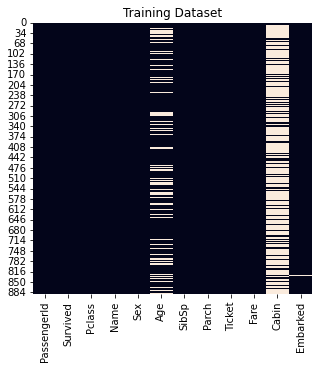

In [7]:
plot_missing_data(load_data, "Training Dataset")

* passengers who survived

In [8]:
load_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
load_data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [10]:
def bar_chart_stacked(dataset, feature, stacked=True):
    survived = dataset[dataset["Survived"]==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked,figsize=(5,5))
    
    

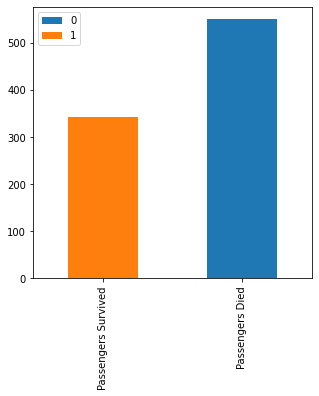

In [11]:
bar_chart_stacked(load_data, "Survived")

In [12]:
load_data['Sex'].value_counts().to_frame()

,Sex
male,577
female,314


In [13]:
load_data.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

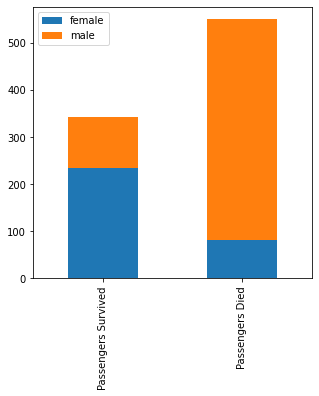

In [14]:
bar_chart_stacked(load_data, 'Sex')

In [15]:
pd.pivot_table(load_data, index="Survived", columns="Pclass", values='Ticket', aggfunc='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [16]:
load_data.groupby(['Pclass']).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


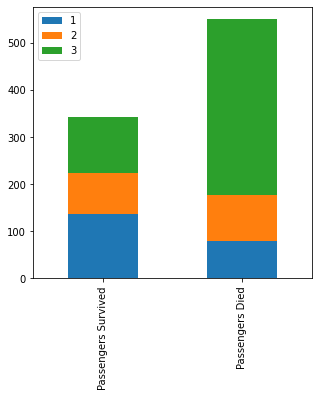

In [17]:
bar_chart_stacked(load_data, 'Pclass')

In [18]:
def bar_chart_compare(dataset, feature1, feature2=None, title=None):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')

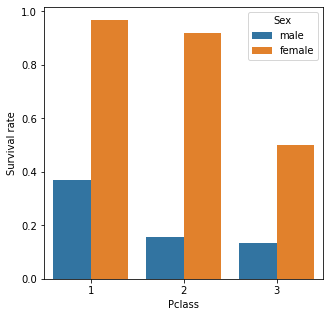

In [19]:
bar_chart_compare(load_data, "Pclass", "Sex")

In [20]:
load_data.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

* function to plot histogram and kernel density estimate

In [21]:
def plot_distribution(dataset, feature, title, bins=30, hist=True, fsize= (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(load_data[feature], color='g', bins=bins, ax=ax)
    
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize=(5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.kdeplot(dataset[feature1].loc[load_data["Survived"]==1],
               shade=True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[load_data["Survived"]==0],
               shade=True, ax=ax, label="Died")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


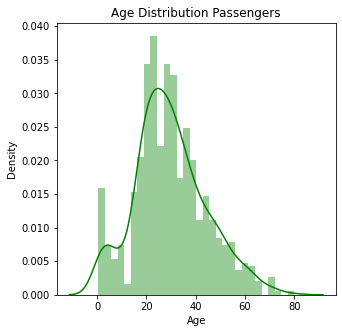

In [22]:
plot_distribution(load_data, "Age", "Age Distribution Passengers")

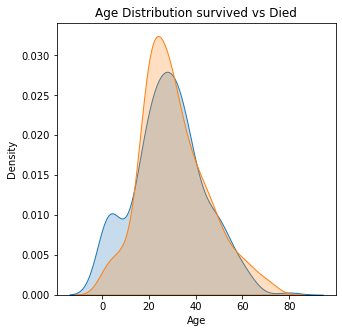

In [23]:
plot_kernel_density_estimate_survivors(load_data, "Age", "Age Distribution survived vs Died")

In [24]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fsize= (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived', data=load_data).set_title(title)

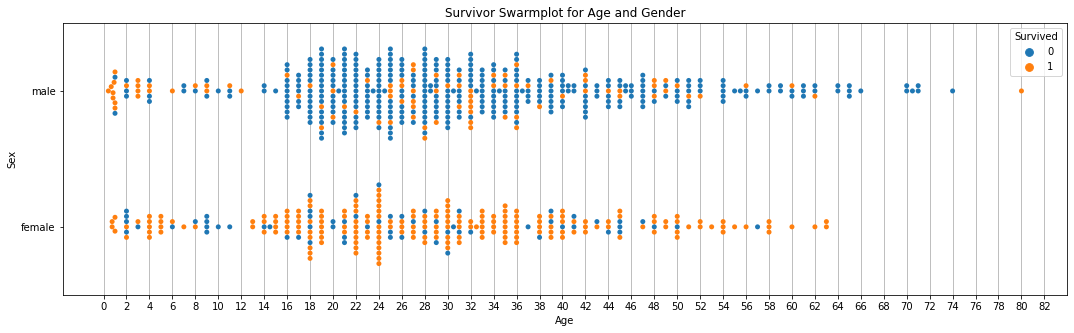

In [25]:
plot_swarm_survivors(load_data, "Sex", "Age", "Survivor Swarmplot for Age and Gender")

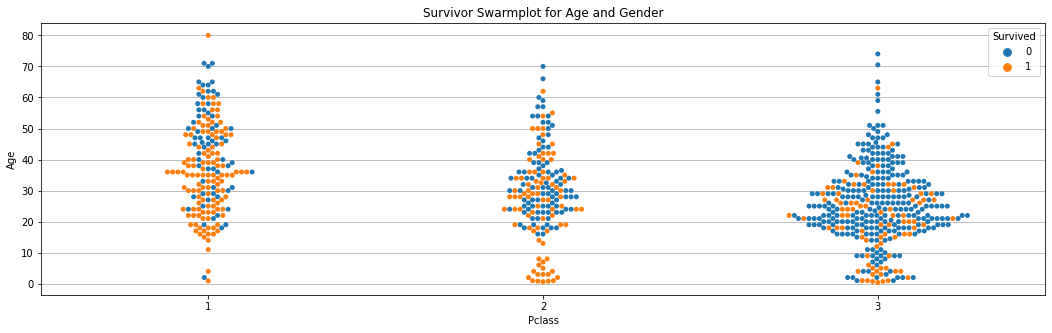

In [26]:
plot_swarm_survivors(load_data, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


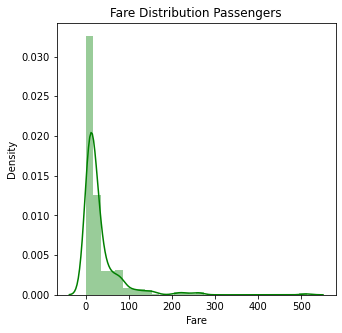

In [27]:
plot_distribution(load_data, "Fare", "Fare Distribution Passengers")

In [28]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')

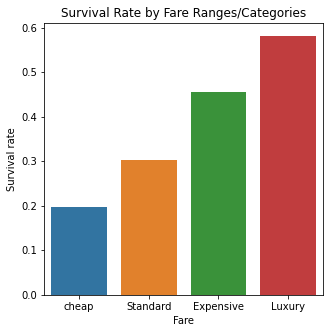

In [29]:
categories = ['cheap','Standard','Expensive','Luxury']

plot_quartiles(load_data, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


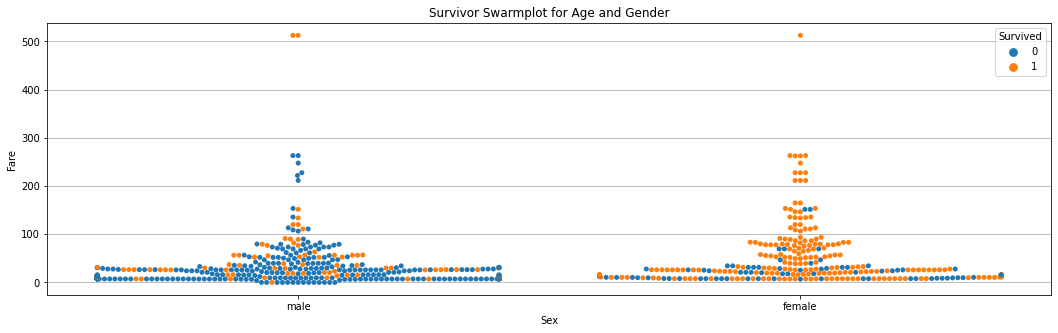

In [30]:
plot_swarm_survivors(load_data, "Fare","Sex","Survivor Swarmplot for Age and Gender")

fares for free?

In [31]:
load_data.loc[load_data.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [32]:
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)

def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)

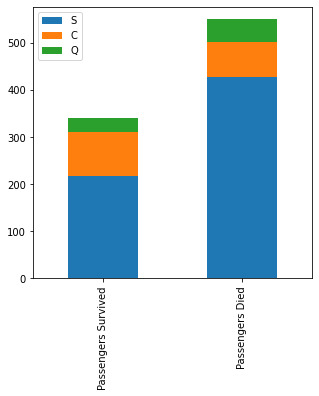

In [33]:
bar_chart_stacked(load_data,'Embarked')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


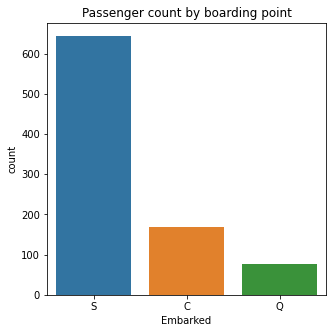

In [34]:
show_countplot(load_data, "Embarked", 'Passenger count by boarding point')

In [35]:
load_data['Embarked'].value_counts().to_frame()

,Embarked
S,644
C,168
Q,77


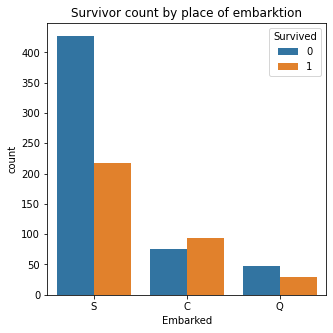

In [36]:
show_compare_countplot(load_data, "Embarked", "Survived", "Survivor count by place of embarktion")

In [37]:
pd.pivot_table(load_data, index = 'Survived', columns = 'Embarked', values = 'Ticket', aggfunc='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


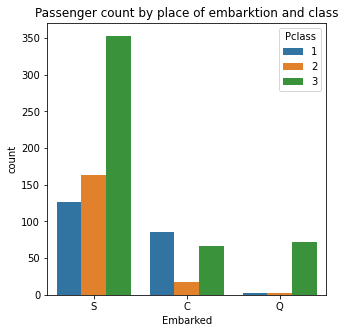

In [38]:
show_compare_countplot(load_data, "Embarked", "Pclass", "Passenger count by place of embarktion and class")

In [39]:
load_data.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()

Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67

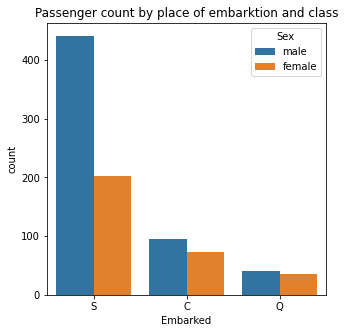

In [40]:
show_compare_countplot(load_data, "Embarked", "Sex", "Passenger count by place of embarktion and class")

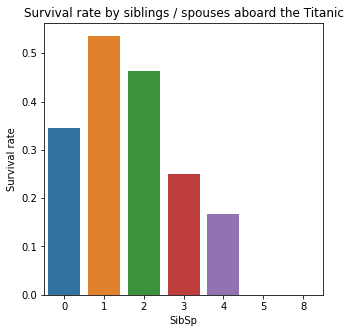

In [41]:
bar_chart_compare(load_data, "SibSp", title = "Survival rate by siblings / spouses aboard the Titanic")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


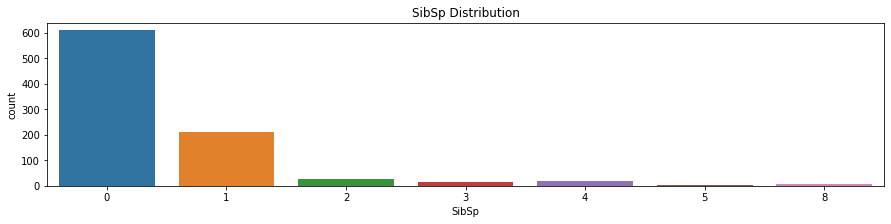

In [42]:
show_countplot(load_data, "SibSp", "SibSp Distribution", (15,3))

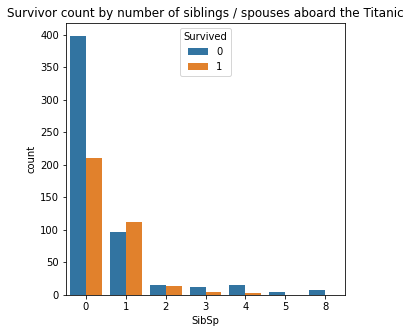

In [43]:
show_compare_countplot(load_data, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


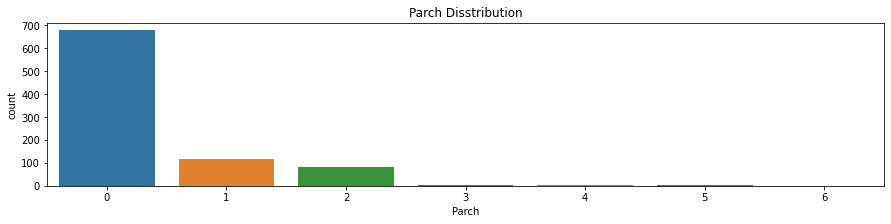

In [44]:
show_countplot(load_data, "Parch", 'Parch Disstribution', (15,3))

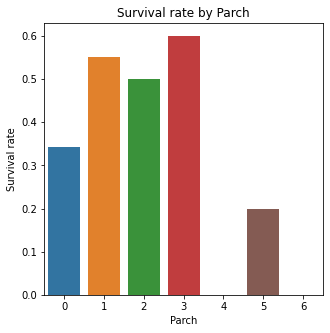

In [45]:
bar_chart_compare(load_data, "Parch", title="Survival rate by Parch")

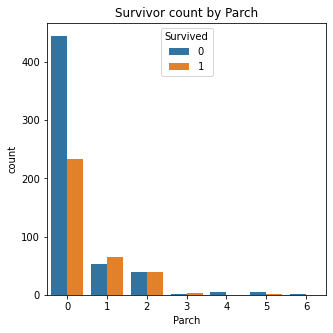

In [46]:
show_compare_countplot(load_data, "Parch", "Survived", "Survivor count by Parch")

## Feature Engineering

creating a new feature with name column

In [47]:
# pd.unique(load_data['Name'])

In [48]:
load_data['Title']=load_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
testds['Title']=testds['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


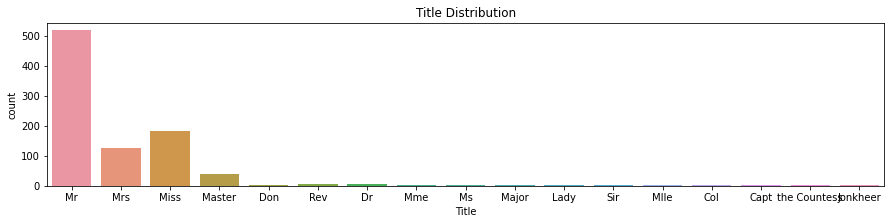

In [49]:
show_countplot(load_data, "Title", 'Title Distribution', (15,3))

In [50]:
# #merge in 'Mr'
# load_data['Title'].replace(to_replace=['Don','Major','Sir','Col','Capt','Jonkheer'], value='Mr', inplace=True)
# #merge in 'Mrs'
# load_data['Title'].replace(to_replace=['Mme','Ms','Lady','Mlle','the Countess'], value='Mrs', inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


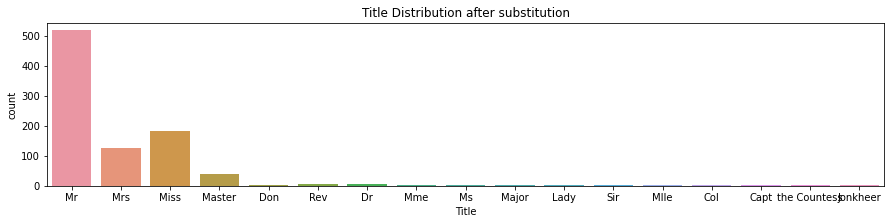

In [51]:
show_countplot(load_data,"Title", 'Title Distribution after substitution', (15,3))

In [52]:
label = "Survived"

classes = load_data[label].unique().tolist()
print(f"Label classes: {classes}")

Label classes: [0, 1]


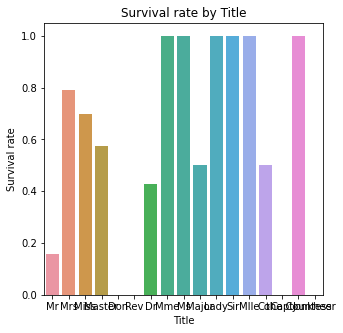

In [53]:
bar_chart_compare(load_data, "Title", title="Survival rate by Title")

* Feature Cabin and Ticket

In [54]:
load_data[['Cabin', 'Ticket']]

,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,B42,112053
888,NaN,W./C. 6607
889,C148,111369


In [55]:
#Extract Leading Letter
load_data['Ticket_2letter'] = load_data.Ticket.apply(lambda x: x[:2])
testds['Ticket_2letter'] = testds.Ticket.apply(lambda x: x[:2])

In [56]:
#Extract Ticket Length
load_data['Ticket_len'] = load_data.Ticket.apply(lambda x: len(x))
testds['Ticket_len'] = testds.Ticket.apply(lambda x: len(x))

In [57]:
#Extract Number of Cabins
load_data['Cabin_num'] = load_data.Ticket.apply(lambda x: len(x.split()))
testds['Cabin_num'] = testds.Ticket.apply(lambda x: len(x.split()))

In [58]:
#Extract Leading Letter
load_data['Cabin_1letter'] = load_data.Ticket.apply(lambda x: x[:1])
testds['Cabin_1letter'] = testds.Ticket.apply(lambda x: x[:1])

* Family Size

In [59]:
load_data['Fam_size'] = load_data['SibSp'] + load_data['Parch'] + 1
testds['Fam_size'] = testds['SibSp'] + testds['Parch'] + 1

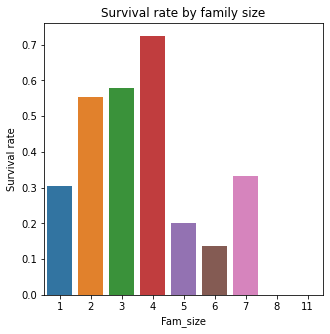

In [60]:
bar_chart_compare(load_data, "Fam_size", title = "Survival rate by family size")

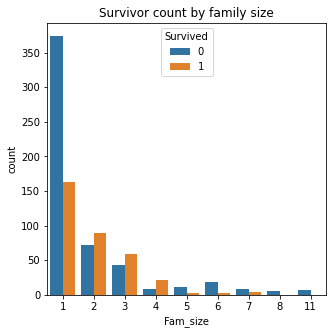

In [61]:
show_compare_countplot(load_data, "Fam_size","Survived", "Survivor count by family size")

In [62]:
load_data['Fam_type'] = pd.cut(load_data.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
testds['Fam_type'] = pd.cut(testds.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

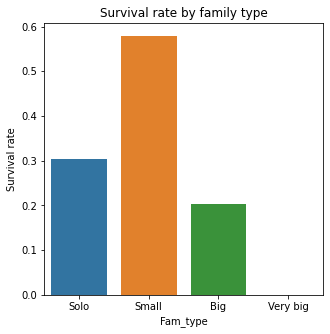

In [63]:
bar_chart_compare(load_data, "Fam_type", title = "Survival rate by family type")

In [64]:
load_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter,Fam_size,Fam_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2,A,2,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2,P,2,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,ST,16,2,S,1,Solo
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1,1,2,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1,3,1,Solo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,21,6,1,2,1,Solo
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,11,6,1,1,1,Solo
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,W.,10,2,W,4,Small
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,11,6,1,1,1,Solo


## Split Data

In [65]:
train_ds = load_data.sample(frac=0.70, random_state=1)

val_ds = load_data.drop(train_ds.index)

In [66]:
train_ds.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter,Fam_size,Fam_type
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S,Mrs,17,5,1,1,1,Solo
223,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S,Mr,34,6,1,3,1,Solo
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S,Miss,SO,10,2,S,1,Solo
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q,Miss,33,6,1,3,1,Solo
535,536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.2500,NaN,S,Miss,F.,12,2,F,3,Small


In [67]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds, label=label)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_ds, label=label)

/opt/conda/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
2022-10-14 05:54:02.677592: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Specify features

In [68]:
pclass = tfdf.keras.FeatureUsage(name="Pclass")
fare = tfdf.keras.FeatureUsage(name="Fare")
title = tfdf.keras.FeatureUsage(name="Title")
embarked = tfdf.keras.FeatureUsage(name="Embarked")
famtype = tfdf.keras.FeatureUsage(name="Fam_type")
ticketlen = tfdf.keras.FeatureUsage(name="Ticket_len")
ticket2letter = tfdf.keras.FeatureUsage(name="Ticket_2letter")

all_features = [pclass, fare, title, embarked, famtype, ticketlen, ticket2letter]

In [69]:
#Specify the model with features
model_2 = tfdf.keras.RandomForestModel(verbose=2, features=all_features, num_trees=500, max_depth=5, exclude_non_specified_features=True)

## Evaluate the model

In [70]:
model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=val_ds)

print(model_2.evaluate(val_ds, return_dict=True))

 1/10 [==>...........................] - ETA: 1:00

2022-10-14 05:54:09.867463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 10
[INFO kernel.cc:393] Number of examples: 624
[INFO data_spec_inference.cc:290] 24 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Ticket_2letter (29 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:290] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Title (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 624
Number of columns: 8

Number of columns by type:
	CATEGORICAL: 5 (62.5%)
	NUMERICAL: 3 (37.5%)

Columns:

CATEGORICAL: 5 (62.5%)
	0: "Embarked" CATEGORICAL num-nas:1 (0.160256%) 

5/5 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8240
{'loss': 0.0, 'accuracy': 0.8239700198173523}


## Save model

In [71]:
model_2.save("titanic_model")

2022-10-14 05:54:13.964139: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Plot the model

In [72]:
tfdf.model_plotter.plot_model_in_colab(model_2, tree_idx=0, max_depth=4)

## Load model

In [73]:
evaluator_model = tf.keras.models.load_model('titanic_model')

evaluator_model.summary()

Model: "random_forest_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________


[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 500 root(s), 13530 node(s), and 7 input feature(s).
[INFO kernel.cc:848] Use fast generic engine


## Submit

In [74]:
ids = testds.pop('PassengerId')

In [75]:
testds = tfdf.keras.pd_dataframe_to_tf_dataset(testds)

In [76]:
check =pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [77]:
# Preprocessing of test data, fit model
pred =  model_2.predict(testds)
thresh = 0.5
pred_c = tf.cast(pred > thresh, tf.int64)
pred_num = tf.reshape(pred_c,[len(pred_c)]).numpy()
# Save test predictions to file
output = pd.DataFrame({'PassengerId':ids,'Survived': pred_num.squeeze()})
output.dtypes
output.to_csv('submission.csv', index=False)
output.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [78]:
# os.remove("/kaggle/working/submission.csv")